----------------------Q 3-----------------------

Gibbs sampler (a) - (d)


In [537]:
import numpy as np
import pandas as pd
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [583]:
# todo: sample everything from self.rang_gen to control the random seed (works as numpy.random)
class GibbsSampler:
    def __init__(self, n_docs, n_topics, n_words, alpha, beta, random_seed=None):
        """
        :param n_docs:          number of documents
        :param n_topics:        number of topics
        :param n_words:         number of words in vocabulary
        :param alpha:           dirichlet parameter on topic mixing proportions
        :param beta:            dirichlet parameter on topic word distributions
        :param random_seed:     random seed of the sampler
        """
        self.n_docs = n_docs
        self.n_topics = n_topics
        self.n_words = n_words
        self.alpha = alpha
        self.beta = beta
        self.rand_gen = np.random.RandomState(random_seed)

        self.docs_words = np.zeros((self.n_docs, self.n_words))
        self.docs_words_test = None
        self.loglike = None
        self.loglike_test = None
        self.do_test = False

        self.A_dk = np.zeros((self.n_docs, self.n_topics))  # number of words in document d assigned to topic k
        self.B_kw = np.zeros((self.n_topics, self.n_words))  # number of occurrences of word w assigned to topic k
        self.A_dk_test = np.zeros((self.n_docs, self.n_topics))
        self.B_kw_test = np.zeros((self.n_topics, self.n_words))

        self.theta = np.ones((self.n_docs, self.n_topics)
                             ) / self.n_topics  # theta[d] is the distribution over topics in document d, nomalised so that row sum =1
        self.phi = np.ones((self.n_topics, self.n_words)) / self.n_words  # phi[k] is the distribution words in topic k, nomalised so that row sun=1

        self.topics_space = np.arange(self.n_topics)
        self.topic_doc_words_distr = np.zeros((self.n_topics, self.n_docs, self.n_words))  # z_id|x_id, theta, phi

    def init_sampling(self, docs_words, docs_words_test=None,
                      theta=None, phi=None, n_iter=0, save_loglike=False):
        assert np.all(docs_words.shape == (self.n_docs, self.n_words)), "docs_words shape=%s must be (%d, %d)" % (
            docs_words.shape, self.n_docs, self.n_words)
        self.n_docs = docs_words.shape[0]

        self.docs_words = docs_words
        self.docs_words_test = docs_words_test

        self.do_test = (docs_words_test is not None)

        if save_loglike:
            self.loglike = np.zeros(n_iter+1)             #n_iter is the number of iteration, plus one initial loglikelihood

            if self.do_test:
                self.loglike_test = np.zeros(n_iter+1)


        self.A_dk.fill(0.0)
        self.B_kw.fill(0.0)
        self.A_dk_test.fill(0.0)
        self.B_kw_test.fill(0.0)

        self.init_params(theta, phi)

    def init_params(self, theta=None, phi=None):
        if theta is None:
            self.theta = np.ones((self.n_docs, self.n_topics)) / self.n_topics
        else:
            self.theta = theta.copy()

        if phi is None:
            self.phi = np.ones((self.n_topics, self.n_words)) / self.n_words
        else:
            self.phi = phi.copy()

        self.update_topic_doc_words()
            #print('z_id',self.topic_doc_words_distr)
        self.sample_counts()

    def run(self, docs_words, docs_words_test=None,
            n_iter=100, theta=None, phi=None, save_loglike=False):
        """
        docs_words is a matrix n_docs * n_words; each entry
        is a number of occurrences of a word in a document
        docs_words_test does not influence the updates and is used
        for validation
        """
        self.init_sampling(docs_words, docs_words_test,
                           theta, phi, n_iter, save_loglike)
        self.update_loglike(-1)                             #record the initial loglikelihood
        self.update_loglike_test(docs_words_test,-1)        #record the initial testing loglikelihood
        for iteration in range(n_iter):
            
            print("{}/{}".format(iteration+1,n_iter),end="\r",flush=True)
    
            self.update_params()
                                    #print('z_id', self.topic_doc_words_distr)
                                    #print('A_dk', self.A_dk)
            if save_loglike:
                self.update_loglike(iteration)
                self.update_loglike_test(docs_words_test, iteration)   #testing loglikelihood
                                    #print("likelihood ", self.loglike)
        return self.to_return_from_run()

    def to_return_from_run(self):
        return self.topic_doc_words_distr, self.theta, self.phi

    def update_params(self):
        """
        Samples theta and phi, then computes the distribution of
        z_id and samples counts A_dk, B_kw from it
        """
        # todo: sample theta and phi

        #sample theta from dirichlet (A_{d,k}+alpha), since dim(theta)=ndoc * ntopic , we need to update for each d, so for each row
        for d in range(self.n_docs):
            self.theta[d,:] = np.random.dirichlet(self.A_dk[d,:] + self.alpha)

        #sample phi from dirichlet (B_{k,w}+beta), dim(phi) = ntopics * nwords
        for k in range(self.n_topics):
            self.phi[k,:] = np.random.dirichlet(self.B_kw[k,:] + self.beta)


        self.update_topic_doc_words()
        #print('thishif',self.topic_doc_words_distr[0,0,:])
        self.sample_counts()        #update A and B

    def update_topic_doc_words(self):
        """
        Computes the distribution of z_id|x_id, theta, phi
        """
        self.topic_doc_words_distr = np.repeat(
            self.theta.T[:, :, None], self.n_words, axis=2) * self.phi[:, None, :]
        self.topic_doc_words_distr /= self.theta.dot(self.phi)[None, :, :]

    def sample_counts(self):
        """
        For each document and each word, samples from z_id|x_id, theta, phi
        and adds the results to the counts A_dk and B_kw
        """

        self.A_dk.fill(0)
        self.B_kw.fill(0)

        if self.do_test:
            self.A_dk_test.fill(0)
            self.B_kw_test.fill(0)

        # todo: sample a topic for each (doc, word) and update A_dk, B_kw correspondingly
        self.docs_topic  = np.zeros((self.n_docs,self.n_words))       #np.zeros((self.n_docs, self.n_words))
        for docs in range(self.n_docs):
            for word in range(self.n_words):
                for _ in range(self.docs_words[docs, word]):           #for number of occurance of the word
                    sample_topic = np.random.choice(self.topics_space,p = self.topic_doc_words_distr[:,docs,word])  #sample topic for each word in each document
                    self.A_dk[docs, sample_topic] += 1
                    self.B_kw[sample_topic, word] += 1
            #update A_dk
            #print(self.docs_topic[docs,:])
            #unique , counts = np.unique(self.docs_topic[docs,:],return_counts = True)
            #for topic in range(self.n_topics):
             #   self.A_dk[docs,topic] = np.count_nonzero(self.docs_topic[docs,:] == topic)

        #update  B_kw   np.zeros((self.n_topics, self.n_words))

        #for topic in range(self.n_topics):
         #   for word in range(self.n_words):
          #      self.B_kw[topic , word] = np.count_nonzero(self.docs_topic[:,word] == topic )

        pass

    def update_loglike(self, iteration):
        """
        Updates loglike of the data, omitting the constant additive term
        with Gamma functions of hyperparameters
        """
        # todo: implement log-like
        # Hint: use scipy.special.gammaln (imported as gammaln) for log(gamma)

        #theta prior and phi prior
        theta_prior = self.n_docs * (gammaln(self.n_topics * self.alpha) - self.n_docs * self.n_topics * gammaln(self.alpha))  #gammaln is the log of gamma function
        phi_prior = self.n_topics * (gammaln(self.n_words * self.beta) - self.n_topics * self.n_words * gammaln(self.beta))

        # p(z_id) and p(x_id)
        p_zid = np.sum(np.multiply((self.A_dk + self.alpha -1) , np.log(self.theta)))
                #print('p_zid',self.p_zid)
        p_xid = np.sum(np.multiply((self.B_kw + self.beta -1) , np.log(self.phi)))
                #   print("p_xid",self.p_xid)
        self.loglike[iteration+1] = theta_prior + phi_prior + p_zid + p_xid     #plus one since the first one is the initial loglike
        #print("loglikelihood is ", self.loglike)
        '''
        ll = 0
        ll += self.n_topics * gammaln(self.n_words * self.beta)
        ll += - self.n_words * self.n_topics * gammaln(self.beta)
        ll += self.n_docs * gammaln(self.n_topics * self.alpha)
        ll += - self.n_topics * self.n_docs * gammaln(self.alpha)
        ll += ((self.A_dk + self.alpha -1 ) * np.log(self.theta)).sum()
        ll += ((self.B_kw + self.beta - 1) * np.log(self.phi)).sum()
        self.loglike[iteration + 1] = ll
        '''

        pass

    def update_loglike_test(self, docs_words_test, iteration):
        """
        Update testing loglikelihood, using the testing data, theta and phi
        """
        for docs in range(self.n_docs):
            for word in range(self.n_words):
                p = np.matmul(self.theta[docs,:], self.phi[:,word])
                if p!=0:
                    self.loglike_test[iteration+1] += docs_words_test[docs, word] * np.log(p)
        pass

    def get_loglike(self):
        """Returns log-likelihood at each iteration."""
        #self.ll = np.append(self.ll, self.loglike)
        if self.do_test:
            return self.loglike, self.loglike_test
        else:
            return self.loglike



In [584]:
class GibbsSamplerCollapsed(GibbsSampler):
    def __init__(self, n_docs, n_topics, n_words, alpha, beta, random_seed=None):
        """
        :param n_docs:          number of documents
        :param n_topics:        number of topics
        :param n_words:         number of words in vocabulary
        :param alpha:           dirichlet parameter on topic mixing proportions
        :param beta:            dirichlet parameter on topic word distributions
        :param random_seed:     random seed of the sampler
        """
        super().__init__(n_docs, n_topics, n_words, alpha, beta, random_seed)   # __init__ in GibbsSampler

        # topics assigned to each (doc, word)
        self.doc_word_samples = np.ndarray((self.n_docs, self.n_words), dtype=object)
        self.doc_word_samples_test = self.doc_word_samples.copy()

    def init_params(self, theta=None, phi=None):
        # z_id are initialized uniformly
        for doc in range(self.n_docs):
            for word in range(self.n_words):
                if self.do_test:
                    additional_samples = self.docs_words_test[doc, word]
                else:
                    additional_samples = 0

                sampled_topics = self.rand_gen.choice(self.topics_space, size=self.docs_words[doc, word] + additional_samples)

                sampled_topics_train = sampled_topics[:self.docs_words[doc, word]]      #.docs_words is the how many times the word occurs
                self.doc_word_samples[doc, word] = sampled_topics_train.copy()          # now each cell is an np.array !!!,

                sample, counts = np.unique(sampled_topics_train, return_counts=True)

                self.A_dk[doc, sample] += counts        #for each element
                self.B_kw[sample, word] += counts

                if self.do_test:
                    sampled_topics_test = sampled_topics[self.docs_words[doc, word]:]
                    self.doc_word_samples_test[doc, word] = sampled_topics_test.copy()

                    sample, counts = np.unique(sampled_topics_test, return_counts=True)

                    self.A_dk_test[doc, sample] += counts
                    self.B_kw_test[sample, word] += counts


    def update_params(self):
        """
        Computes the distribution of z_id.
        Sampling of A_dk, B_kw is done automatically as
        each new z_id updates these counters
        """
        # todo: sample a topic for each (doc, word) and update A_dk, B_kw correspondingly
        # Hint: you can update A_dk, B_kw after each sampling instead of re-computing the whole matrix

        #self.docs_topic_col =  np.ndarray(self.n_docs, self.n_words)
        for docs in range(self.n_docs):
            for word in range(self.n_words):
                for index_of_oldtopic ,old_topic in enumerate(self.doc_word_samples[docs,word]):          #self.docs_word_samples is z_id


                    #print("\n old A=", self.A_dk)
                    #print("the old topic=", old_topic)

                    self.A_dk[docs, old_topic] -= 1 #if self.A_dk[docs, old_topic] >= 1 else 0)
                    self.B_kw[old_topic, word] -= 1 #if self.B_kw[old_topic, word] >= 1 else 0)

                    #print("\n A after minus one", self.A_dk)

                    p = (self.A_dk[docs, :] + self.alpha) * ((self.B_kw[:,word]+self.beta)/np.sum(self.B_kw, axis=1))   #might have mistake

                    p /= np.sum(p)    #the probability of topic of i th word in j th document

                    #print("\n the p is ", p)

                    new_topic = np.random.choice(len(p), p= p)       #the sampled new topic for thid word

                    #print("\n the new topic is", new_topic)

                    self.doc_word_samples[docs,word][index_of_oldtopic] = new_topic    #update the new topic
                    self.A_dk[docs, new_topic] += 1
                    self.B_kw[new_topic, word] += 1             #update A and B

                    #print("\n the updated A is", self.A_dk)

        pass

    def update_loglike(self, iteration):
        """
        Updates loglike of the data, omitting the constant additive term
        with Gamma functions of hyperparameters
        """
        # todo: implement log-like, this is different from the standard LDA
        ll = 0
        ll += self.n_docs * gammaln(self.n_topics * self.alpha)
        ll += - self.n_topics * self.n_docs * gammaln(self.alpha)
        ll += self.n_topics * gammaln(self.n_words * self.beta)
        ll += - self.n_words * self.n_topics * gammaln(self.beta)
        ll += gammaln(self.A_dk + self.alpha).sum()
        ll += - gammaln(np.sum(self.A_dk,axis = 1) + self.n_topics * self.alpha).sum()
        ll += gammaln(self.B_kw + self.beta).sum()
        ll += - gammaln(np.sum(self.B_kw, axis = 1) + self.n_words * self.beta).sum()


        self.loglike[iteration+1] = ll    #plus one since the first one is the initial loglike

        pass

    def update_loglike_test(self, docs_words_test, iteration):
        """
        Updating the testing log likelihood using alpha, A, B, beta, and formula (20) in 1(d)

        """
        for docs in range(self.n_docs):
            for word in range(self.n_words):
                p1 = self.alpha + self.A_dk[docs, :] -1
                p2 = self.n_topics * self.alpha -1 + self.A_dk[docs, :].sum()
                p3 = self.B_kw[:,word] + self.beta - 1
                p4 = self.B_kw.sum(axis = 1) + self.n_words * self.beta -1
                p11 = p1/p2
                p22 = p3/p4
                p = np.matmul(p11, p22)
                #print("p=",p)
                if p!=0:
                    self.loglike_test[iteration+1] += docs_words_test[docs, word] * np.log(p)



    def to_return_from_run(self):
        return self.doc_word_samples



In [541]:
def read_data(filename):
    """
    Reads the text data and splits into train/test.
    Examples:
    docs_words_train, docs_words_test = read_data('./code/toyexample.data')
    nips_train, nips_test = read_data('./code/nips.data')
    :param filename:    path to the file
    :return:
    docs_words_train:   training data, [n_docs, n_words] numpy array
    docs_words_test:    test data, [n_docs, n_words] numpy array
    """
    data = pd.read_csv(filename, dtype=int, sep=' ', names=['doc', 'word', 'train', 'test'])

    n_docs = np.amax(data.loc[:, 'doc'])
    n_words = np.amax(data.loc[:, 'word'])

    docs_words_train = np.zeros((n_docs, n_words), dtype=int)           #training and testing have the same dimension
    docs_words_test = np.zeros((n_docs, n_words), dtype=int)

    docs_words_train[data.loc[:, 'doc'] - 1, data.loc[:, 'word'] - 1] = data.loc[:, 'train']
    docs_words_test[data.loc[:, 'doc'] - 1, data.loc[:, 'word'] - 1] = data.loc[:, 'test']
    print('train', docs_words_train)
    print('test',docs_words_test)
    return docs_words_train, docs_words_test


def autocor(data, lag):
    '''
    function compute the auto-correlation with lag
    :param data: the input data we need to compute the correlation from
    :param lag:  the lag
    :return:     the auto-correlation with stated lag
    '''

    length = data.shape[0]
    mean = sum(data)/length
    data_copy = data.copy()
    s0 = (np.square(data_copy - mean).sum())/length

    y_1 = data[:length-lag]
    y_2 = data[lag:]
    s_lag = np.matmul((y_1 - mean),(y_2 - mean))/length

    return s_lag/s0


Running toyexample.data with the standard sampler
train [[10 10 10 10  0  0]
 [ 0  0 10 10 10 10]
 [10 10  0  0 10 10]
 [ 5  5  0  0  0  0]
 [ 0  0  5  5  0  0]
 [ 0  0  0  0  5  5]]
test [[1 1 1 1 0 0]
 [0 0 1 1 1 1]
 [1 1 0 0 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
[[[0.36609069 0.24914916 0.06704366 0.22173532 0.04181027 0.05417089]
  [0.23643769 0.01493524 0.22389958 0.3989349  0.06070389 0.0650887 ]
  [0.15908102 0.39421222 0.14495009 0.03442997 0.25984792 0.        ]
  [0.01291916 0.2416299  0.10208572 0.05240961 0.41066547 0.18029014]
  [0.121343   0.14281265 0.23096912 0.04752186 0.19893218 0.25842119]
  [0.19044185 0.08601348 0.06092141 0.03145374 0.38346373 0.24770579]
  [0.34371909 0.15739309 0.01528643 0.15832976 0.15405879 0.17121283]
  [0.29814708 0.07194046 0.25444211 0.3301005  0.         0.03566381]
  [0.01183391 0.23315909 0.16302207 0.28409595 0.         0.3056732 ]
  [0.10051238 0.0269372  0.31166949 0.0729501  0.20185387 0.28607696]]]


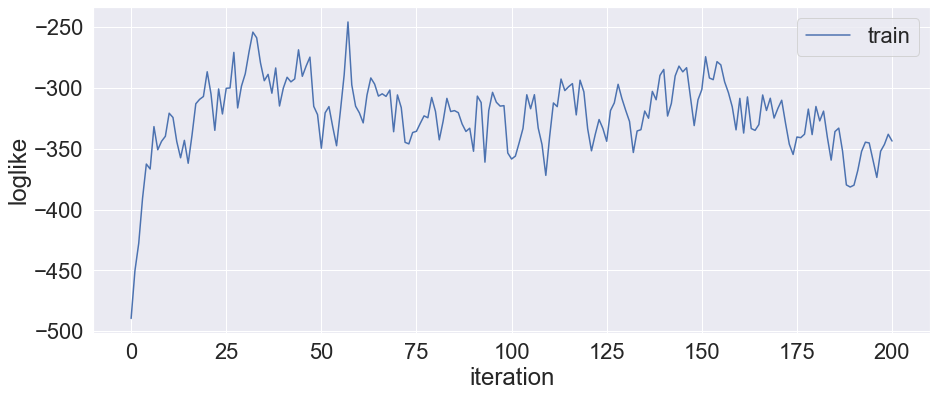

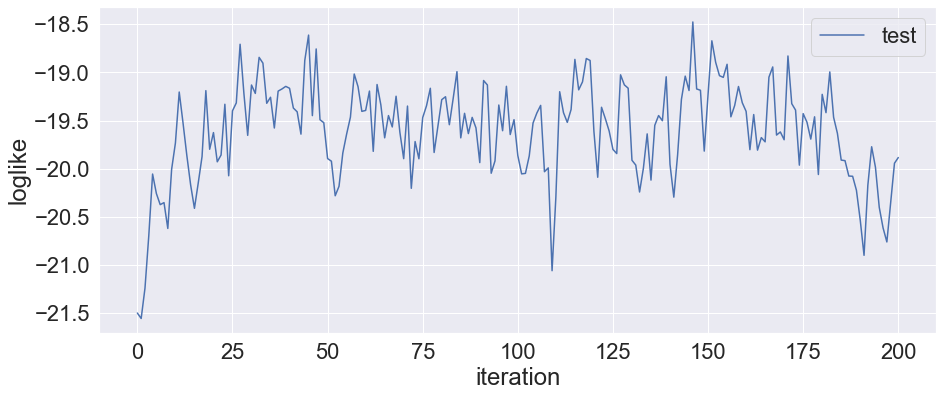

Running toyexample.data with the collapsed sampler
[[ 2.  1.  3.  2.  0.  0.]
 [ 0.  0.  7.  5.  7. 10.]
 [ 3. 16.  3.  1.  0.  0.]
 [ 0.  0.  5.  0.  0.  2.]
 [ 3.  0.  2.  0.  9.  2.]
 [ 4.  5.  2.  8.  1.  0.]
 [ 6.  1.  1.  0.  0.  0.]
 [ 5.  0.  0.  2.  2.  5.]
 [ 0.  1.  0.  3.  6.  6.]
 [ 2.  1.  2.  4.  0.  0.]]


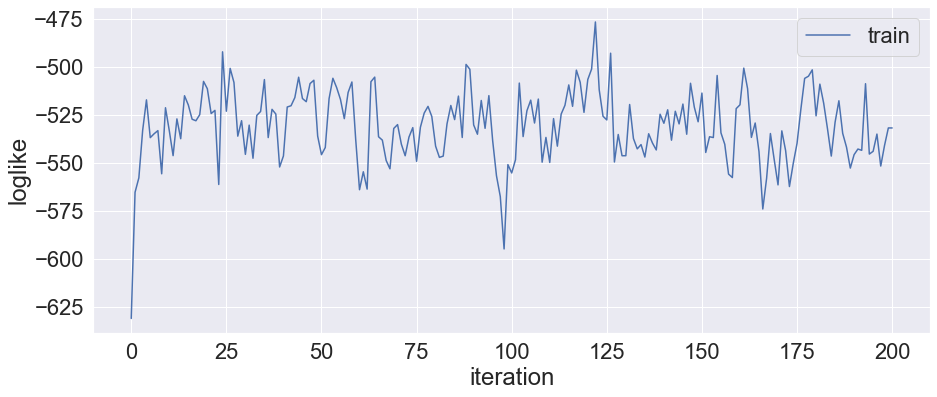

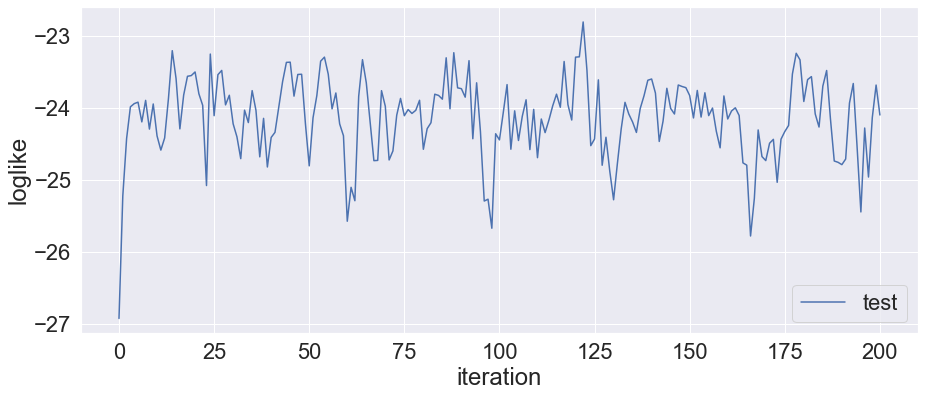

In [542]:
def main():

    print('Running toyexample.data with the standard sampler')

    docs_words_train, docs_words_test = read_data('toyexample.data.txt')    #the train is 6(document) * 6(word), for (i,j), the number is the occurance of jth word
                                                                            # in i th document
    n_docs, n_words = docs_words_train.shape
    n_topics = 10
    alpha = 1
    beta = 1
    random_seed = 0

    '''
    #tuning alpha
    plt.subplots(figsize=(15, 6))
    for beta in [1,5,10]:
        sampler_alpha = GibbsSampler(n_docs=n_docs, n_topics=n_topics, n_words=n_words, alpha=alpha, beta=beta, random_seed=random_seed)
        topic_doc_words_distr, theta, phi = sampler_alpha.run(docs_words_train, docs_words_test, n_iter=1000, save_loglike=True)
        ll_train_alpha, ll_test_alpha = sampler_alpha.get_loglike()
        plt.plot(ll_test_alpha, label="beta = {}".format(beta))
    plt.xlabel("iteration")
    plt.ylabel("log-likelihood of testing standard Gibb ")
    plt.legend(loc="lower right")
    '''
    '''
    #tuning the number of topic
    for n_topics in [2,3,4,5]:
        sample_topic = GibbsSampler(n_docs=n_docs, n_topics=n_topics, n_words=n_words, alpha=alpha, beta=beta, random_seed=random_seed)
        topic_doc_words_distr, theta, phi = sample_topic.run(docs_words_train, docs_words_test, n_iter=1000, save_loglike=True)
        ll_train_topic, ll_test_topic = sample_topic.get_loglike()
        plt.plot(ll_test_topic, label="K = {}".format(n_topics))
    plt.xlabel("iteration")
    plt.ylabel("log_likelihood of testing standard Gibbs")
    plt.legend(loc = "lower right")
    '''




    sampler = GibbsSampler(n_docs=n_docs, n_topics=n_topics, n_words=n_words,
                           alpha=alpha, beta=beta, random_seed=random_seed)

    topic_doc_words_distr, theta, phi = sampler.run(docs_words_train, docs_words_test,
                                                    n_iter=200, save_loglike=True)

    print(phi * [phi > 1e-2])

    like_train, like_test = sampler.get_loglike()

    plt.subplots(figsize=(15, 6))
    plt.plot(like_train, label='train')
    plt.ylabel('loglike')
    plt.xlabel('iteration')
    plt.legend()
    plt.show()

    '''
    plt.subplots(figsize=(15, 6))
    plot_set = []
    for lag in range(200):                     #auto plot of train std gibbs, 20 iterations burn-in
        auto = autocor(like_train[30:], lag)
        #plt.scatter(lag,auto, color = "grey")
        plot_set.append(auto)
    plt.plot(plot_set)
    plt.ylim(-0.1,0.1)
    plt.xlabel("lag")
    plt.ylabel("auto-correlation of training standard Gibbs")
    plt.show()
    '''



    plt.subplots(figsize=(15, 6))
    plt.plot(like_test, label='test')
    plt.ylabel('loglike')
    plt.xlabel('iteration')
    plt.legend()
    plt.show()

    '''
    plt.subplots(figsize=(15, 6))
    plot_set = []
    for lag in range(200):                     #auto plot of testing std gibbs, 20 iterations burn-in
        auto = autocor(like_test[30:], lag)
        #plt.scatter(lag,auto, color = "grey")
        plot_set.append(auto)
    plt.plot(plot_set)
    plt.ylim(-0.1,0.1)
    plt.xlabel("lag")
    plt.ylabel("auto-correlation of testing standard Gibbs")
    plt.show()
    '''


    print('Running toyexample.data with the collapsed sampler')

    sampler_collapsed = GibbsSamplerCollapsed(n_docs=n_docs, n_topics=n_topics, n_words=n_words,
                                              alpha=alpha, beta=beta, random_seed=random_seed)

    doc_word_samples = sampler_collapsed.run(docs_words_train, docs_words_test,
                                             n_iter=200, save_loglike=True)
    topic_counts = np.zeros((n_topics, 6))
    for doc in range(doc_word_samples.shape[0]):
        for word in range(doc_word_samples.shape[1]):
            for topic in doc_word_samples[doc, word]:
                topic_counts[topic, word] += 1

    print(topic_counts)


    '''
    plt.subplots(figsize=(15, 6))
    for beta in [1,5,10]:                         #tuning alpha
        sampler_alpha = GibbsSamplerCollapsed(n_docs=n_docs, n_topics=n_topics, n_words=n_words, alpha=alpha, beta=beta, random_seed=random_seed)
        _ = sampler_alpha.run(docs_words_train, docs_words_test, n_iter=1000, save_loglike=True)
        ll_train_alpha, ll_test_alpha = sampler_alpha.get_loglike()
        plt.plot(ll_train_alpha, label="beta = {}".format(beta))
    plt.xlabel("iteration")
    plt.ylabel("log-likelihood of train collapsed Gibbs")
    plt.legend(loc="lower right")
    '''

    '''
    #tuning the number of topic
    for n_topics in [2,3,4,5]:
        sample_topic = GibbsSamplerCollapsed(n_docs=n_docs, n_topics=n_topics, n_words=n_words, alpha=alpha, beta=beta, random_seed=random_seed)
        _ = sample_topic.run(docs_words_train, docs_words_test, n_iter=1000, save_loglike=True)
        ll_train_topic, ll_test_topic = sample_topic.get_loglike()
        plt.plot(ll_test_topic, label="K = {}".format(n_topics))
    plt.xlabel("iteration")
    plt.ylabel("log_likelihood of testing collapsed Gibbs")
    plt.legend(loc = "lower right")
    '''




    like_train, like_test = sampler_collapsed.get_loglike()

    plt.subplots(figsize=(15, 6))
    plt.plot(like_train, label='train')
    plt.ylabel('loglike')
    plt.xlabel('iteration')
    plt.legend()
    plt.show()

    '''
    plt.subplots(figsize=(15, 6))
    plot_set = []
    for lag in range(200):                     #auto plot of train collapsed gibbs, 15 iterations burn-in
        auto = autocor(like_train[30:], lag)
        #plt.scatter(lag,auto, color = "blue", marker = 'o')
        plot_set.append(auto)
    plt.plot(plot_set)
    plt.ylim(-0.1,0.1)
    plt.xlabel("lag")
    plt.ylabel("auto-correlation of training Collapsed Gibbs")
    plt.show()
    '''




    plt.subplots(figsize=(15, 6))
    plt.plot(like_test, label='test')
    plt.ylabel('loglike')
    plt.xlabel('iteration')
    plt.legend()
    plt.show()

    '''
    plt.subplots(figsize=(15, 6))
    plot_set = []
    for lag in range(200):                     #auto plot of test col gibbs, 15 iterations burn-in
        auto = autocor(like_test[30:], lag)
        #plt.scatter(lag,auto, color = "blue", marker = 'o')
        plot_set.append(auto)
    plt.plot(plot_set)
    plt.ylim(-0.1,0.1)
    plt.xlabel("lag")
    plt.ylabel("auto-correlation of testing Collapsed Gibbs")
    plt.show()
    '''
if __name__ == '__main__':
    main()


NIPS data (e) - (f)

In [547]:
def docs_words(data):
    """
    generate matrix counting the word in each document, (D=1684, W=12419 ), both training and testing
    
    return
    matrix_train : frequency matrix of training data

    """
    matrix_train = np.zeros((1684, 12419))
    for i in data[:-1]:                   # the last row is empty
        temp = i.split(" ")      # docs @ word @ numer_of_occurance_in_train  @ in_test
        matrix_train[int(temp[0])-1, int(temp[1])-1] += int(temp[2])
    return matrix_train


In [270]:
def tf(data):
    """
    generate a tf matrix, where the row represents the document, the column represents the word
    data : the frequency matrix
    
    return
    matrix : tf matrix
    """
    matrix = data.copy()
    if 0 in np.sum(data, axis =1):
        D = matrix.shape[0]
        W = matrix.shape[1]
        for doc in range(D):
            row_sum = matrix[doc].sum()      #sum of the row
            if row_sum != 0:
                for word in range(W):
                    matrix[doc, word] /= row_sum
        return matrix

    matrix = data / np.sum(data,axis = 1)[:,np.newaxis]
    return matrix

In [423]:
def idf(data):
    """
    generate idf matrix
    data : frequency matrix D*W
    
    return :
    vector : idf vector dim = W
    """
    W = data.shape[1]
    D = data.shape[0]
    vector = np.zeros(W)
    counter = 1+np.count_nonzero(data, axis = 0)   #return a vector counting the nonzero terms along each the column
    for word in range(W):
        vector[word] = np.log(D/(counter[word]))
    
    return vector

In [426]:
def find_max(data, top):
    """
    find the first top number of words with highest tf-idf value
    """
    W = data.shape[1]
    temp = data.sum(axis=0)
    word_index_list = []          # the list of word selected
    count = 0
    while count < top:
        maximum = max(temp)
        index = list(temp).index(maximum)
        word_index_list.append(index)
        temp[index] = 0
        count += 1
    return word_index_list
        
        

In [594]:
with open("nips.data") as f:
        data = f.read()
nips = data.split("\n")
with open("nips.vocab") as f:
    vocab = list(f)
    
train = docs_words(nips)    #the frequency matrix of training and testing data
tf_train = tf(train)
idf_train = idf(train)
tf_idf_train = tf_train * idf_train

In [599]:
idf_train

array([5.34948565, 5.03103192, 3.51690419, ..., 5.48301705, 4.86397784,
       6.73578001])

In [586]:
def nip_preprocessing():
    """
    Load the nips data,prune the data, split it into train and test sets
    """
    
    with open("nips.data") as f:
        data = f.read()
    nips = data.split("\n")
    with open("nips.vocab") as f:
        vocab = list(f)
    
    train = docs_words(nips)    #the frequency matrix of training and testing data
    tf_train = tf(train)
    idf_train = idf(train)
    tf_idf_train = tf_train * idf_train
    
    a = find_max(tf_idf_train,100)      #top 500 words
    word = []
    for i in a:
        word = np.append(word, vocab[i][:-1])
        
    nips_Gibbs_data = []         #creat pd Dataframe for sampling
    for i in nips[:-1]:
        temp = i.split(" ")
        temp2 = [int(i) for i in temp]      #transfer to int
        if temp2[1] in a:
            nips_Gibbs_data.append(temp2)
    
    df = pd.DataFrame(nips_Gibbs_data,columns = ['doc', 'word', 'train', 'test'])    #creat data frame
    
    #split train and test
    n_docs = np.amax(df.loc[:, 'doc'])
    n_words = np.amax(df.loc[:, 'word'])
    print("n_docs", n_docs)
    print("n_words", n_words)
    docs_words_train = np.zeros((n_docs, n_words), dtype=int)           #training and testing have the same dimension
    docs_words_test = np.zeros((n_docs, n_words), dtype=int)
    
    docs_words_train[df.loc[:, 'doc'] - 1, df.loc[:, 'word'] - 1] = df.loc[:, 'train']
    docs_words_test[df.loc[:, 'doc'] - 1, df.loc[:, 'word'] - 1] = df.loc[:, 'test']
    print('train', docs_words_train)
    print('test',docs_words_test)
    
    return docs_words_train, docs_words_test

In [587]:
train, test =nip_preprocessing()

n_docs 1684
n_words 12262
train [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
test [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [588]:
n_docs, n_words = train.shape
n_topics = 10
alpha = 1
beta = 1
random_seed = 0
sampler = GibbsSampler(n_docs=n_docs, n_topics=n_topics, n_words=n_words, alpha=alpha, beta=beta, random_seed=random_seed)

topic_doc_words_distr, theta, phi = sampler.run(train, test, n_iter=200, save_loglike=True)    
print(phi * [phi > 1e-2])  
like_train, like_test = sampler.get_loglike()

plt.subplots(figsize=(15, 6))
plt.plot(like_train, label='train')
plt.ylabel('loglike')
plt.xlabel('iteration')
plt.legend()
plt.show()

plt.subplots(figsize=(15, 6))
plt.plot(like_test, label='test')
plt.ylabel('loglike')
plt.xlabel('iteration')
plt.legend()
plt.show()



KeyboardInterrupt: 

(1684, 12382)

In [589]:
with open("nips.data") as f:
    data = f.read()
nips = data.split("\n")
with open("nips.vocab") as f:
    vocab = list(f)
    
train = docs_words(nips)    #the frequency matrix of training and testing data
tf_train = tf(train)
idf_train = idf(train)
tf_idf_train = tf_train * idf_train
    
a = find_max(tf_idf_train,500)      #top 100 words, we need to relabel the these 100 words
b = sorted(a)


word = []
for i in b:
    word = np.append(word, vocab[i][:-1])
nips_Gibbs_data = []         #creat pd Dataframe for sampling
for i in nips[:-1]:
    temp = i.split(" ")
    temp2 = [int(j) for j in temp]      #transfer to int
    if temp2[1] in b:
        temp2[1] = b.index(temp2[1])+1   #adding number not index
        nips_Gibbs_data.append(temp2)
df = pd.DataFrame(nips_Gibbs_data,columns = ['doc', 'word', 'train', 'test'])    #creat data frame

In [590]:
    n_docs = np.amax(df.loc[:, 'doc'])
    n_words = np.amax(df.loc[:, 'word'])
    print("n_docs", n_docs)
    print("n_words", n_words)
    docs_words_train = np.zeros((n_docs, n_words), dtype=int)           #training and testing have the same dimension
    docs_words_test = np.zeros((n_docs, n_words), dtype=int)
    
    docs_words_train[df.loc[:, 'doc'] - 1, df.loc[:, 'word'] - 1] = df.loc[:, 'train']
    docs_words_test[df.loc[:, 'doc'] - 1, df.loc[:, 'word'] - 1] = df.loc[:, 'test']

n_docs 1684
n_words 500


In [593]:
n_docs, n_words = docs_words_train.shape
n_topics = 3
alpha = 1
beta = 1
random_seed = 0
sampler = GibbsSampler(n_docs=n_docs, n_topics=n_topics, n_words=n_words, alpha=alpha, beta=beta, random_seed=random_seed)

topic_doc_words_distr, theta, phi = sampler.run(docs_words_train, docs_words_test, n_iter=100, save_loglike=True)    
print(phi * [phi > 1e-2])  
like_train, like_test = sampler.get_loglike()

plt.subplots(figsize=(15, 6))
plt.plot(like_train, label='train')
plt.ylabel('loglike')
plt.xlabel('iteration')
plt.legend()
plt.show()

plt.subplots(figsize=(15, 6))
plt.plot(like_test, label='test')
plt.ylabel('loglike')
plt.xlabel('iteration')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
#print the first 20 words for each topic
for topic in phi:
    temp = topic.copy()
    lst = []
    for _ in range(20):
        max_index = list(temp).index(max(temp))
        lst.append(vocab[b[max_index]][:-1])
        temp[max_index] = 0
    print(lst,"\n")